# Introduction

The main goal of this notebook is to perform a logistic regression and validate its assumptions, trying to obtain a decent score.

I will perform the following steps:
- check some plots and aggregate data
- fill missing values
- check assumptions of logistic regression
- build and optimize the model

# Loading libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings

from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
warnings.filterwarnings('ignore')
sns.set_theme()

# Importing the dataset

In [3]:
orig_train = pd.read_csv("/kaggle/input/titanic/train.csv", sep=",")
orig_test = pd.read_csv("/kaggle/input/titanic/test.csv", sep=",")

In [4]:
train = orig_train.copy()
test = orig_test.copy()

# A quick glance at the data

In [5]:
pd.concat([train, test], axis=0).drop(columns='Survived').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


<AxesSubplot:xlabel='Age', ylabel='Count'>

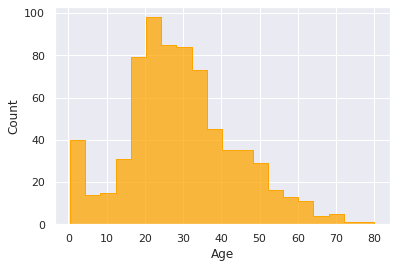

In [6]:
sns.histplot(x=train.Age, data=train, element="step", color="orange")

In [7]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

<AxesSubplot:xlabel='Fare', ylabel='Count'>

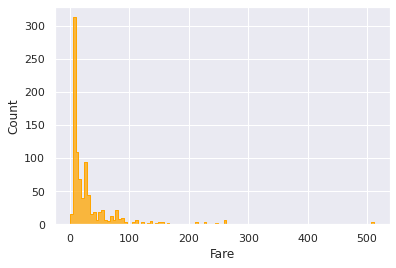

In [8]:
sns.histplot(x=train.Fare, data=train, element="step", color="orange")

In [9]:
train.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 248, dtype: int64

In [10]:
train.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [11]:
train.Name.value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

In [12]:
train.Name.str.extract(r'([A-Za-z]*\.)').value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Col.           2
Mlle.          2
Mme.           1
Ms.            1
Capt.          1
Lady.          1
Jonkheer.      1
Don.           1
Countess.      1
Sir.           1
dtype: int64

In [13]:
train.Ticket.value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [14]:
(train.SibSp + train.Parch).value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
dtype: int64

# Reorganizing features

At first I will fill every null value and then reorganize Name, Cabin, SibSp and Parch in categorical variables.

In [15]:
def fix_df (df):
    df['Embarked'] = df.Embarked.fillna('S')
    df["Age"] = df.Age.fillna(df.Age.median())
    df["Fare"] = df.Fare.fillna(df.Fare.median())
    
    df['Cabin'] = df.Cabin.apply(lambda x : 'yes' if isinstance(x, str) else 'no')
    df['title_Name'] = df.Name.str.extract(r'([A-Za-z]*\.)')
    title_head = df.title_Name.value_counts() > 7
    df['title_Name'] = df.title_Name.apply(lambda x: x if title_head[x] == True  else 'Other')
    df['n_family'] = df.SibSp + df.Parch
    
    df.drop(columns=['Name', 'Parch', 'SibSp', 'Ticket'], inplace=True)
    
    return df


In [16]:
fix_df(train)


PassengerId  Survived  Pclass     Sex   Age     Fare Cabin Embarked  \
0              1         0       3    male  22.0   7.2500    no        S   
1              2         1       1  female  38.0  71.2833   yes        C   
2              3         1       3  female  26.0   7.9250    no        S   
3              4         1       1  female  35.0  53.1000   yes        S   
4              5         0       3    male  35.0   8.0500    no        S   
..           ...       ...     ...     ...   ...      ...   ...      ...   
886          887         0       2    male  27.0  13.0000    no        S   
887          888         1       1  female  19.0  30.0000   yes        S   
888          889         0       3  female  28.0  23.4500    no        S   
889          890         1       1    male  26.0  30.0000   yes        C   
890          891         0       3    male  32.0   7.7500    no        Q   

    title_Name  n_family  
0          Mr.         1  
1         Mrs.         1  
2        Miss.         0  
3         Mrs.         1  
4          Mr.         0  
..         ...       ...  
886      Other         0  
887      Miss.         0  
888      Miss.         3  
889        Mr.         0  
890        Mr.         0  

[891 rows x 10 columns]

In [17]:
fix_df(test)

PassengerId  Pclass     Sex   Age      Fare Cabin Embarked title_Name  \
0            892       3    male  34.5    7.8292    no        Q        Mr.   
1            893       3  female  47.0    7.0000    no        S       Mrs.   
2            894       2    male  62.0    9.6875    no        Q        Mr.   
3            895       3    male  27.0    8.6625    no        S        Mr.   
4            896       3  female  22.0   12.2875    no        S       Mrs.   
..           ...     ...     ...   ...       ...   ...      ...        ...   
413         1305       3    male  27.0    8.0500    no        S        Mr.   
414         1306       1  female  39.0  108.9000   yes        C      Other   
415         1307       3    male  38.5    7.2500    no        S        Mr.   
416         1308       3    male  27.0    8.0500    no        S        Mr.   
417         1309       3    male  27.0   22.3583    no        C    Master.   

     n_family  
0           0  
1           1  
2           0  
3           0  
4           2  
..        ...  
413         0  
414         0  
415         0  
416         0  
417         2  

[418 rows x 9 columns]

# Plotting data

In [18]:
def select_type (df):
        cat = []
        num = []
        
        for i in df.columns:
            if (i == 'Survived') or (i == 'PassengerId') :
                continue
            elif df.dtypes[i] == 'float64':
                num.append(i)
            else:
                cat.append(i)
               
        return cat, num

In [19]:
cat, num = select_type(train)

In [20]:
cat

['Pclass', 'Sex', 'Cabin', 'Embarked', 'title_Name', 'n_family']

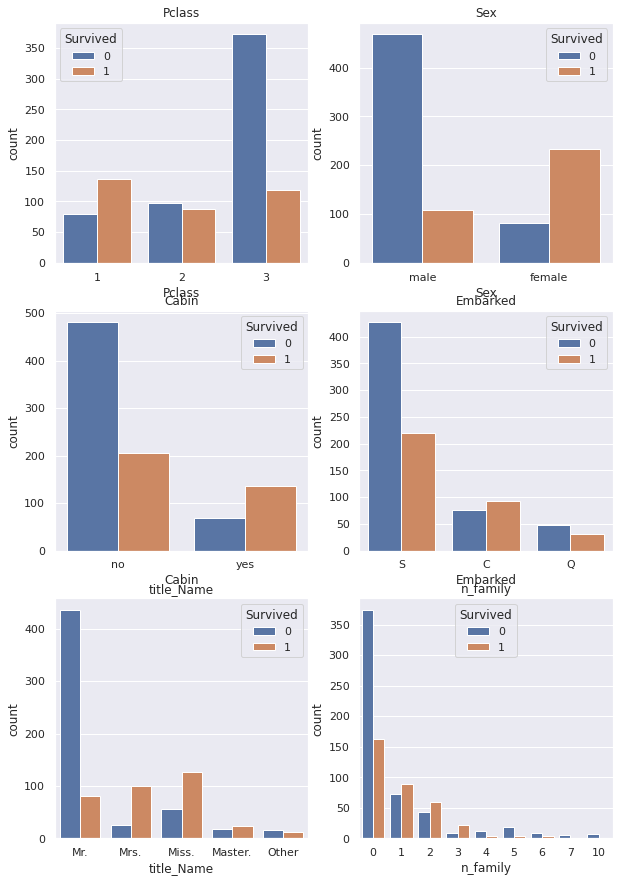

In [21]:
lcat = len(cat)
fig, axes = plt.subplots(round((lcat)/2), 2, figsize=(10, round(lcat/2)*5))

for ax, i in zip(axes.flat, cat):
    sns.countplot(ax=ax, x=train[i], hue=train.Survived, data=train)
    ax.set_title(i)  

In [22]:
train[['title_Name', 'Age']].query("title_Name == 'Master.'")

title_Name    Age
7      Master.   2.00
16     Master.   2.00
50     Master.   7.00
59     Master.  11.00
63     Master.   4.00
65     Master.  28.00
78     Master.   0.83
125    Master.  12.00
159    Master.  28.00
164    Master.   1.00
165    Master.   9.00
171    Master.   4.00
176    Master.  28.00
182    Master.   9.00
183    Master.   1.00
193    Master.   3.00
261    Master.   3.00
278    Master.   7.00
305    Master.   0.92
340    Master.   2.00
348    Master.   3.00
386    Master.   1.00
407    Master.   3.00
445    Master.   4.00
480    Master.   9.00
489    Master.   9.00
549    Master.   8.00
709    Master.  28.00
751    Master.   6.00
755    Master.   0.67
787    Master.   8.00
788    Master.   1.00
802    Master.  11.00
803    Master.   0.42
819    Master.  10.00
824    Master.   2.00
827    Master.   1.00
831    Master.   0.83
850    Master.   4.00
869    Master.   4.00

In [23]:
train.query("n_family > 4")

PassengerId  Survived  Pclass     Sex   Age      Fare Cabin Embarked  \
13            14         0       3    male  39.0   31.2750    no        S   
16            17         0       3    male   2.0   29.1250    no        Q   
25            26         1       3  female  38.0   31.3875    no        S   
27            28         0       1    male  19.0  263.0000   yes        S   
50            51         0       3    male   7.0   39.6875    no        S   
59            60         0       3    male  11.0   46.9000    no        S   
63            64         0       3    male   4.0   27.9000    no        S   
68            69         1       3  female  17.0    7.9250    no        S   
71            72         0       3  female  16.0   46.9000    no        S   
88            89         1       1  female  23.0  263.0000   yes        S   
119          120         0       3  female   2.0   31.2750    no        S   
159          160         0       3    male  28.0   69.5500    no        S   
164          165         0       3    male   1.0   39.6875    no        S   
167          168         0       3  female  45.0   27.9000    no        S   
171          172         0       3    male   4.0   29.1250    no        Q   
180          181         0       3  female  28.0   69.5500    no        S   
182          183         0       3    male   9.0   31.3875    no        S   
201          202         0       3    male  28.0   69.5500    no        S   
233          234         1       3  female   5.0   31.3875    no        S   
261          262         1       3    male   3.0   31.3875    no        S   
266          267         0       3    male  16.0   39.6875    no        S   
278          279         0       3    male   7.0   29.1250    no        Q   
324          325         0       3    male  28.0   69.5500    no        S   
341          342         1       1  female  24.0  263.0000   yes        S   
360          361         0       3    male  40.0   27.9000    no        S   
386          387         0       3    male   1.0   46.9000    no        S   
437          438         1       2  female  24.0   18.7500    no        S   
438          439         0       1    male  64.0  263.0000   yes        S   
480          481         0       3    male   9.0   46.9000    no        S   
541          542         0       3  female   9.0   31.2750    no        S   
542          543         0       3  female  11.0   31.2750    no        S   
610          611         0       3  female  39.0   31.2750    no        S   
634          635         0       3  female   9.0   27.9000    no        S   
638          639         0       3  female  41.0   39.6875    no        S   
642          643         0       3  female   2.0   27.9000    no        S   
678          679         0       3  female  43.0   46.9000    no        S   
683          684         0       3    male  14.0   46.9000    no        S   
686          687         0       3    male  14.0   39.6875    no        S   
787          788         0       3    male   8.0   29.1250    no        Q   
792          793         0       3  female  28.0   69.5500    no        S   
813          814         0       3  female   6.0   31.2750    no        S   
819          820         0       3    male  10.0   27.9000    no        S   
824          825         0       3    male   2.0   39.6875    no        S   
846          847         0       3    male  28.0   69.5500    no        S   
850          851         0       3    male   4.0   31.2750    no        S   
863          864         0       3  female  28.0   69.5500    no        S   
885          886         0       3  female  39.0   29.1250    no        Q   

    title_Name  n_family  
13         Mr.         6  
16     Master.         5  
25        Mrs.         6  
27         Mr.         5  
50     Master.         5  
59     Master.         7  
63     Master.         5  
68       Miss.         6  
71       Miss.         7  
88       Miss.         5  
119      Mi

Many passengers with large family have Pclass equal 3.

In [24]:
train.query("(n_family > 0) and (n_family < 5)").sample(30)

PassengerId  Survived  Pclass     Sex    Age      Fare Cabin Embarked  \
529          530         0       2    male  23.00   11.5000    no        S   
118          119         0       1    male  24.00  247.5208   yes        C   
111          112         0       3  female  14.50   14.4542    no        C   
394          395         1       3  female  24.00   16.7000   yes        S   
803          804         1       3    male   0.42    8.5167    no        C   
743          744         0       3    male  24.00   16.1000    no        S   
416          417         1       2  female  34.00   32.5000    no        S   
236          237         0       2    male  44.00   26.0000    no        S   
46            47         0       3    male  28.00   15.5000    no        Q   
224          225         1       1    male  38.00   90.0000   yes        S   
533          534         1       3  female  28.00   22.3583    no        C   
291          292         1       1  female  19.00   91.0792   yes        C   
336          337         0       1    male  29.00   66.6000   yes        S   
432          433         1       2  female  42.00   26.0000    no        S   
375          376         1       1  female  28.00   82.1708    no        C   
7              8         0       3    male   2.00   21.0750    no        S   
858          859         1       3  female  24.00   19.2583    no        C   
69            70         0       3    male  26.00    8.6625    no        S   
353          354         0       3    male  25.00   17.8000    no        S   
65            66         1       3    male  28.00   15.2458    no        C   
698          699         0       1    male  49.00  110.8833   yes        C   
861          862         0       2    male  21.00   11.5000    no        S   
371          372         0       3    male  18.00    6.4958    no        S   
104          105         0       3    male  37.00    7.9250    no        S   
259          260         1       2  female  50.00   26.0000    no        S   
558          559         1       1  female  39.00   79.6500   yes        S   
268          269         1       1  female  58.00  153.4625   yes        S   
618          619         1       2  female   4.00   39.0000   yes        S   
585          586         1       1  female  18.00   79.6500   yes        S   
799          800         0       3  female  30.00   24.1500    no        S   

    title_Name  n_family  
529        Mr.         3  
118        Mr.         1  
111      Miss.         1  
394       Mrs.         2  
803    Master.         1  
743        Mr.         1  
416       Mrs.         2  
236        Mr.         1  
46         Mr.         1  
224        Mr.         1  
533       Mrs.         2  
291       Mrs.         1  
336        Mr.         1  
432       Mrs.         1  
375       Mrs.         1  
7      Master.         4  
858       Mrs.         3  
69         Mr.         2  
353        Mr.         1  
65     Master.         2  
698        Mr.         2  
861        Mr.         1  
371        Mr.         1  
104        Mr.         2  
259       Mrs.         1  
558       Mrs.         2  
268       Mrs.         1  
618      Miss.         3  
585      Miss.         2  
799       Mrs.         2

In [25]:
train.groupby(by=['n_family', 'Sex', 'Pclass', 'Survived'])['PassengerId'].count().head(50)

n_family  Sex     Pclass  Survived
0         female  1       0             1
                          1            33
                  2       0             3
                          1            29
                  3       0            23
                          1            37
          male    1       0            50
                          1            25
                  2       0            65
                          1             7
                  3       0           232
                          1            32
1         female  1       1            39
                  2       0             2
                          1            17
                  3       0            14
                          1            15
          male    1       0            19
                          1            12
                  2       0            14
                          1             1
                  3       0            23
                          1             5

In [26]:
train[['title_Name', 'Age']].query("title_Name == 'Mrs.'")

title_Name   Age
1         Mrs.  38.0
3         Mrs.  35.0
8         Mrs.  27.0
9         Mrs.  14.0
15        Mrs.  55.0
..         ...   ...
871       Mrs.  47.0
874       Mrs.  28.0
879       Mrs.  56.0
880       Mrs.  25.0
885       Mrs.  39.0

[125 rows x 2 columns]

At first glance, plots of Sex and title_Name highlight a major percentage of survived among females. Pclass equals to 1, 2 and C-Embarked indicates a different trend than other variables: I will try to check it in the next plots. 

<AxesSubplot:xlabel='Age', ylabel='Count'>

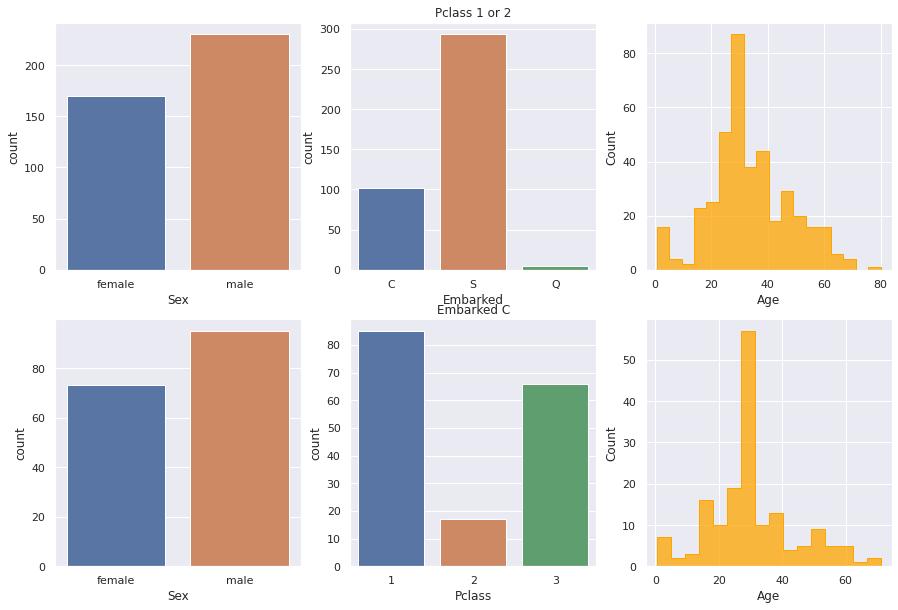

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.countplot(ax=axes[0,0], x=train.query("(Pclass == 1) | (Pclass == 2)").Sex, data=train)
sns.countplot(ax=axes[0,1], x=train.query("(Pclass == 1) | (Pclass == 2)").Embarked, data=train)
axes[0,1].set_title("Pclass 1 or 2")  
sns.histplot(ax=axes[0,2], x=train.query("(Pclass == 1) | (Pclass == 2)").Age, data=train, element="step", color="orange")
sns.countplot(ax=axes[1,0], x=train.query("Embarked == 'C'").Sex, data=train)
sns.countplot(ax=axes[1,1], x=train.query("Embarked == 'C'").Pclass, data=train)
axes[1,1].set_title("Embarked C")  
sns.histplot(ax=axes[1,2], x=train.query("Embarked == 'C'").Age, data=train, element="step", color="orange")

Plotting Pclass only with values 1 and 2 doesn't show particular difference among other data. On the other hand, the plot of C-Embarked shows a strong presence of pclass values equal 1 that we found to have a connection with a higher probability of being survived. 

In [28]:
num

['Age', 'Fare']

<AxesSubplot:xlabel='Survived', ylabel='Age'>

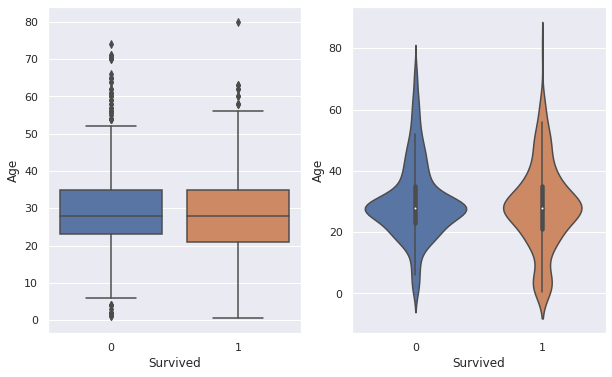

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.boxplot(ax=axes[0], y=train.Age, x=train.Survived, data=train)
sns.violinplot(ax=axes[1], y=train.Age, x=train.Survived, data=train)

<AxesSubplot:xlabel='Age', ylabel='Count'>

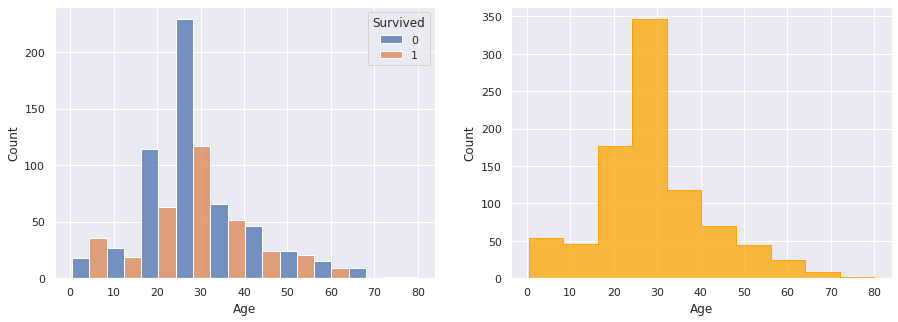

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], x=train.Age, hue=train.Survived, data=train, multiple="dodge", bins=10)
sns.histplot(ax=axes[1], x=train.Age, data=train, bins=10, element="step", color="orange")

<AxesSubplot:xlabel='Age', ylabel='Count'>

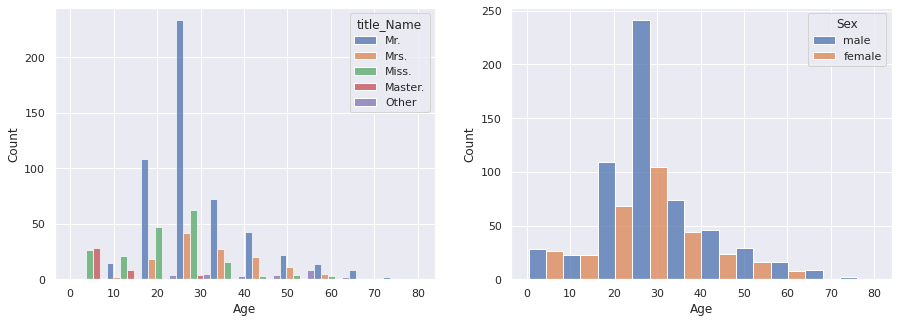

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], x=train.Age, hue=train.title_Name, data=train, multiple="dodge", bins=10)
sns.histplot(ax=axes[1], x=train.Age, hue=train.Sex, data=train, multiple="dodge", bins=10)

The connection between survived, age and sex can be summarized by the title_Name.

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

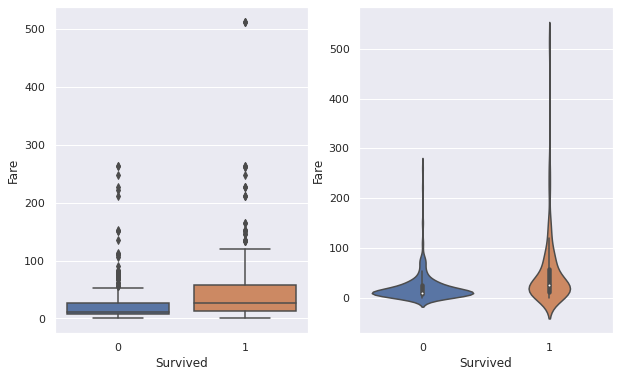

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
sns.boxplot(ax=axes[0], y=train.Fare, x=train.Survived, data=train)
sns.violinplot(ax=axes[1], y=train.Fare, x=train.Survived, data=train)

<AxesSubplot:xlabel='Fare', ylabel='Count'>

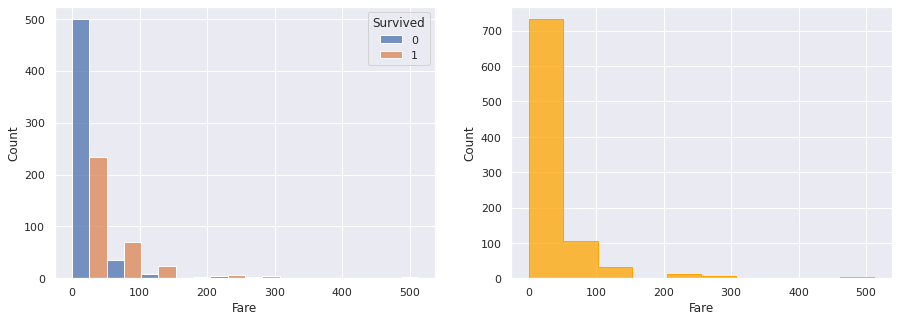

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], x=train.Fare, hue=train.Survived, data=train, multiple="dodge", bins=10)
sns.histplot(ax=axes[1], x=train.Fare, data=train, bins=10, element="step", color="orange")


<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

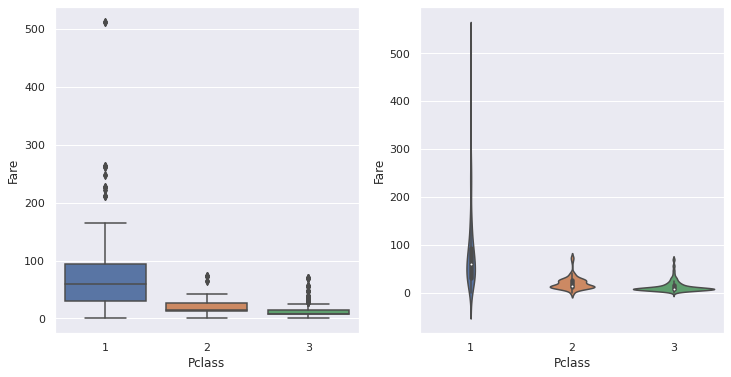

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.boxplot(ax=axes[0], y=train.Fare, x=train.Pclass, data=train)
sns.violinplot(ax=axes[1], y=train.Fare, x=train.Pclass, data=train)

<AxesSubplot:xlabel='Age', ylabel='Fare'>

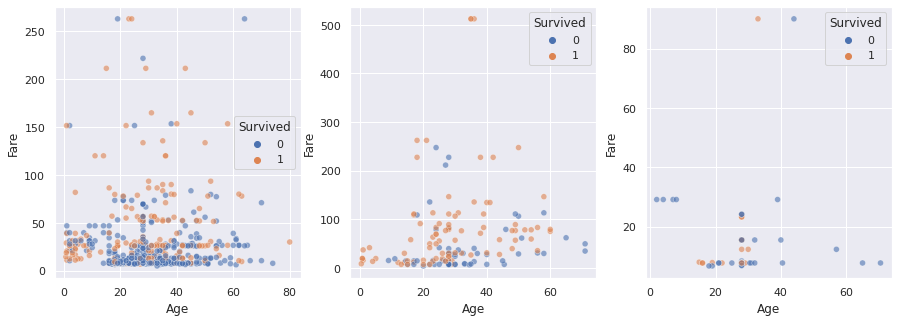

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(ax=axes[0], x=train.query("Embarked == 'S' and Fare != 0").Age, y=train.Fare, hue=train.Survived, data=train, alpha=0.6)
sns.scatterplot(ax=axes[1], x=train.query("Embarked == 'C' and Fare != 0").Age, y=train.Fare, hue=train.Survived, data=train, alpha=0.6)
sns.scatterplot(ax=axes[2], x=train.query("Embarked == 'Q' and Fare != 0").Age, y=train.Fare, hue=train.Survived, data=train, alpha=0.6)

<AxesSubplot:xlabel='Age', ylabel='Fare'>

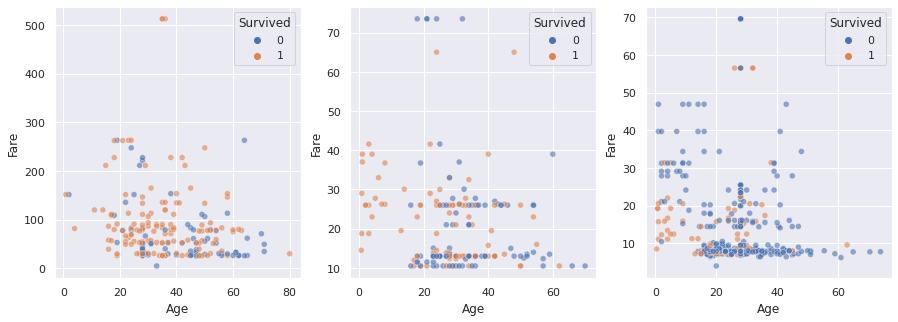

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(ax=axes[0], x=train.query("Pclass == 1 and Fare != 0").Age, y=train.Fare, hue=train.Survived, data=train, alpha=0.6)
sns.scatterplot(ax=axes[1], x=train.query("Pclass == 2 and Fare != 0").Age, y=train.Fare, hue=train.Survived, data=train, alpha=0.6)
sns.scatterplot(ax=axes[2], x=train.query("Pclass == 3 and Fare != 0").Age, y=train.Fare, hue=train.Survived, data=train, alpha=0.6)

There seem to be no particular connections between Age and Fare.  

# Transforming categorical variables into boolean

I will drop Cabin since the ratio between survived and not is so different when we compare who had a filled data and who did not, and considering the initial amount of null values. I will also transform n_family in alone or not. 

In [37]:
train['alone'] = train.n_family.apply(lambda x: x if x == 0 else 1)
train.drop(columns='n_family', inplace=True)
test['alone'] = test.n_family.apply(lambda x: x if x == 0 else 1)
test.drop(columns='n_family', inplace=True)

In [38]:
cat, num = select_type(train)

In [39]:
def dum_cat(df):
    for i in cat:
        if i == 'Cabin':
            continue
        else:
            cls_dum = pd.get_dummies(df[i], prefix=i[0:3], drop_first=True)
            for x in cls_dum.columns:
                df[x] = cls_dum[x]
    
    return df   
    

In [40]:
dum_cat(train)
dum_cat(test)

PassengerId  Pclass     Sex   Age      Fare Cabin Embarked title_Name  \
0            892       3    male  34.5    7.8292    no        Q        Mr.   
1            893       3  female  47.0    7.0000    no        S       Mrs.   
2            894       2    male  62.0    9.6875    no        Q        Mr.   
3            895       3    male  27.0    8.6625    no        S        Mr.   
4            896       3  female  22.0   12.2875    no        S       Mrs.   
..           ...     ...     ...   ...       ...   ...      ...        ...   
413         1305       3    male  27.0    8.0500    no        S        Mr.   
414         1306       1  female  39.0  108.9000   yes        C      Other   
415         1307       3    male  38.5    7.2500    no        S        Mr.   
416         1308       3    male  27.0    8.0500    no        S        Mr.   
417         1309       3    male  27.0   22.3583    no        C    Master.   

     alone  Pcl_2  Pcl_3  Sex_male  Emb_Q  Emb_S  tit_Miss.  tit_Mr.  \
0        0      0      1         1      1      0          0        1   
1        1      0      1         0      0      1          0        0   
2        0      1      0         1      1      0          0        1   
3        0      0      1         1      0      1          0        1   
4        1      0      1         0      0      1          0        0   
..     ...    ...    ...       ...    ...    ...        ...      ...   
413      0      0      1         1      0      1          0        1   
414      0      0      0         0      0      0          0        0   
415      0      0      1         1      0      1          0        1   
416      0      0      1         1      0      1          0        1   
417      1      0      1         1      0      0          0        0   

     tit_Mrs.  tit_Other  alo_1  
0           0          0      0  
1           1          0      1  
2           0          0      0  
3           0          0      0  
4           1          0      1  
..        ...        ...    ...  
413         0          0      0  
414         0          1      0  
415         0          0      0  
416         0          0      0  
417         0          0      1  

[418 rows x 19 columns]

In [41]:
train.drop(columns=cat, inplace=True)
test.drop(columns=cat, inplace=True)

# Feature correlation

<AxesSubplot:>

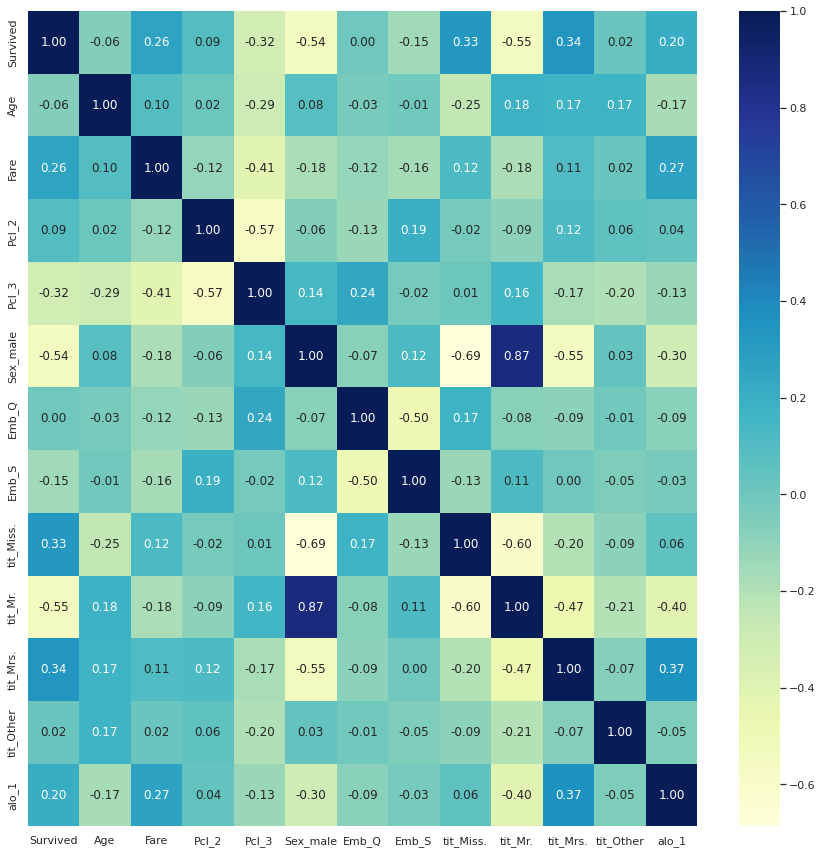

In [42]:
fig = plt.figure(figsize=(15,15))
corrMatrix = train.drop(columns='PassengerId').corr()
sns.heatmap(corrMatrix, annot=True, fmt='.2f', cmap="YlGnBu")

# Logistic regression assumptions  

##### 1) Boolean outcome

<AxesSubplot:xlabel='Survived', ylabel='count'>

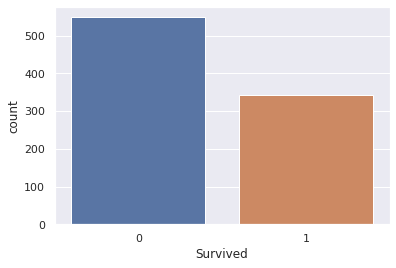

In [43]:
sns.countplot(x=train['Survived'], data=train)

##### 2) Box-Tidwell Test

The relationship between independent variables and their logodds must be linear.

In [44]:
X_bt = train.query("(Fare != 0) and (Age != 0)")
y = X_bt['Survived']
X = X_bt.drop(columns=['Survived','PassengerId'])

In [45]:
X_ln = X[['Fare', 'Age']]
X_ln['Fare_ln'] = X_ln.Fare.apply(lambda x: x * np.log(x))
X_ln['Age_ln'] = X_ln.Age.apply(lambda x: x * np.log(x))
X_ln = sm.add_constant(X_ln, prepend=False)

In [46]:
X_ln.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876 entries, 0 to 890
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Fare     876 non-null    float64
 1   Age      876 non-null    float64
 2   Fare_ln  876 non-null    float64
 3   Age_ln   876 non-null    float64
 4   const    876 non-null    float64
dtypes: float64(5)
memory usage: 41.1 KB


In [47]:
ln_result = GLM(y, X_ln, family=families.Binomial()).fit()
round(ln_result.pvalues, 3)

Fare       0.000
Age        0.051
Fare_ln    0.000
Age_ln     0.101
const      0.349
dtype: float64

The p value for Fare is < 0,01. This means there is no linearity.

In [48]:
y = train['Survived']
X = train.drop(columns=['Survived', 'PassengerId'])
X = sm.add_constant(X, prepend=False)
result = GLM(y, X, family=families.Binomial()).fit()
pred = result.predict(X)
l_odds = np.log(pred / (1 - pred))

<AxesSubplot:>

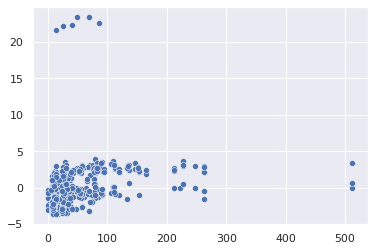

In [49]:
sns.scatterplot(x=X['Fare'].values, y=l_odds)

Scatterplot seems to confirm the previous result.

##### 3) Multicollinearity

Independent variables should not be highly correlated with each other. I will use Variance inflation factor as a measure of multicollinearity. 

In [50]:
def calc_vif(df):
    vif = pd.Series([variance_inflation_factor(df.values, i) for i in range(df.shape[1])], index=df.columns)
    return(vif)

In [51]:
calc_vif(X)

Age            1.561106
Fare           1.714644
Pcl_2          2.092475
Pcl_3          2.789719
Sex_male      39.928022
Emb_Q          1.534460
Emb_S          1.489525
tit_Miss.     33.652796
tit_Mr.        7.673975
tit_Mrs.      26.055271
tit_Other      2.378385
alo_1          1.460939
const        208.744861
dtype: float64

In [52]:
result = GLM(y, X, family=families.Binomial()).fit()
round(result.pvalues, 3)

Age          0.011
Fare         0.725
Pcl_2        0.001
Pcl_3        0.000
Sex_male     0.999
Emb_Q        0.730
Emb_S        0.008
tit_Miss.    0.999
tit_Mr.      0.000
tit_Mrs.     0.999
tit_Other    0.000
alo_1        0.007
const        0.999
dtype: float64

In [53]:
result = GLM(y, X.drop(columns='Sex_male'), family=families.Binomial()).fit()
round(result.pvalues, 3)

Age          0.005
Fare         0.705
Pcl_2        0.000
Pcl_3        0.000
Emb_Q        0.657
Emb_S        0.006
tit_Miss.    0.577
tit_Mr.      0.000
tit_Mrs.     0.029
tit_Other    0.002
alo_1        0.004
const        0.000
dtype: float64

In [54]:
calc_vif(X.drop(columns=['Sex_male', 'Fare']))

Age           1.544319
Pcl_2         1.673784
Pcl_3         2.005227
Emb_Q         1.523050
Emb_S         1.468768
tit_Miss.     4.986224
tit_Mr.       7.669860
tit_Mrs.      4.323240
tit_Other     1.996479
alo_1         1.400879
const        40.565605
dtype: float64

In [55]:
result = GLM(y, X.drop(columns=['Sex_male', 'Fare']), family=families.Binomial()).fit()
round(result.pvalues, 3)

Age          0.005
Pcl_2        0.000
Pcl_3        0.000
Emb_Q        0.642
Emb_S        0.005
tit_Miss.    0.568
tit_Mr.      0.000
tit_Mrs.     0.029
tit_Other    0.002
alo_1        0.004
const        0.000
dtype: float64

<AxesSubplot:>

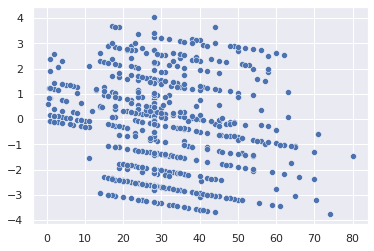

In [56]:
result = GLM(y, X.drop(columns=['Sex_male', 'Fare']), family=families.Binomial()).fit()
pred = result.predict(X.drop(columns=['Sex_male', 'Fare']))
l_odds = np.log(pred / (1 - pred))
sns.scatterplot(x=X['Age'].values, y=l_odds)

In [57]:
result = GLM(y, X['Age'], family=families.Binomial()).fit()
round(result.pvalues, 3)

Age    0.0
dtype: float64

In [58]:
result = GLM(y, X[['Age', 'tit_Miss.', 'tit_Mr.', 'tit_Mrs.', 'tit_Other', 'alo_1']], family=families.Binomial()).fit()
round(result.pvalues, 3)

Age          0.369
tit_Miss.    0.003
tit_Mr.      0.000
tit_Mrs.     0.001
tit_Other    0.340
alo_1        0.602
dtype: float64

In [59]:
result = GLM(y, X.drop(columns=['Sex_male', 'Fare', 'Age']), family=families.Binomial()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      881
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -387.65
Date:                Mon, 13 Feb 2023   Deviance:                       775.30
Time:                        10:29:32   Pearson chi2:                     968.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3698
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Pcl_2         -0.9441      0.269     -3.511      0.000      -1.471      -0.417
Pcl_3         -2.1727      0.247     -8.814      0.000      -2.656      -1.690
Emb_Q         -0.3168      0.379     -0.836      0.403      -1.060       0.426
Emb_S         -0.7113      0.236     -3.019      0.003      -1.173      -0.249
tit_Miss.     -0.0317      0.396     -0.080      0.936      -0.808       0.744
tit_Mr.       -3.0029      0.416     -7.225      0.000      -3.818      -2.188
tit_Mrs.       0.4156      0.415      1.003      0.316      -0.397       1.228
tit_Other     -2.5722      0.590     -4.361      0.000      -3.728      -1.416
alo_1         -0.5424      0.220     -2.470      0.014      -0.973      -0.112
const          3.2179      0.510      6.304      0.000       2.217       4.218
==============================================================================
"""

In [60]:
calc_vif(X.drop(columns=['Sex_male', 'Fare', 'Age']))

Pcl_2         1.594914
Pcl_3         1.750021
Emb_Q         1.503527
Emb_S         1.463280
tit_Miss.     4.767003
tit_Mr.       6.731666
tit_Mrs.      3.653721
tit_Other     1.815411
alo_1         1.371065
const        37.668187
dtype: float64

Being tit_Mr. a categorical variable with more than three categories, and, as the proportion of cases in tit_Master, the reference category, is small, thus the VIF value results accettable.

Age had some missing values and could be explained by the title name and Fare could be explained by Pclass, so I will drop highly correlated and redundant features.

In [61]:
train.drop(columns=['Fare', 'Sex_male', 'Age'], inplace=True)
test.drop(columns=['Fare', 'Sex_male', 'Age'], inplace=True)

##### 4) Outliers

In [62]:
y = train['Survived']
X = train.drop(columns=['Survived', 'PassengerId'])
X = sm.add_constant(X, prepend=False)
result = GLM(y, X, family=families.Binomial()).fit()
influence = result.get_influence()
inf = influence.summary_frame().sort_values(by='standard_resid', ascending=False).query("abs(standard_resid)>3")
inf.head(10)

dfb_Pcl_2  dfb_Pcl_3  dfb_Emb_Q  dfb_Emb_S  dfb_tit_Miss.  dfb_tit_Mr.  \
267   0.029537   0.134661   0.016796   0.071445       0.057873     0.147983   
664   0.029537   0.134661   0.016796   0.071445       0.057873     0.147983   
301   0.039925   0.080545   0.262518   0.030884       0.038762     0.159814   
74    0.009920   0.107552  -0.018156   0.046416      -0.001398     0.052739   
643   0.009920   0.107552  -0.018156   0.046416      -0.001398     0.052739   
400   0.009920   0.107552  -0.018156   0.046416      -0.001398     0.052739   
338   0.009920   0.107552  -0.018156   0.046416      -0.001398     0.052739   
107   0.009920   0.107552  -0.018156   0.046416      -0.001398     0.052739   
286   0.009920   0.107552  -0.018156   0.046416      -0.001398     0.052739   
146   0.009920   0.107552  -0.018156   0.046416      -0.001398     0.052739   

     dfb_tit_Mrs.  dfb_tit_Other  dfb_alo_1  dfb_const   cooks_d  \
267      0.027309       0.098009   0.178169  -0.156645  0.006815   
664      0.027309       0.098009   0.178169  -0.156645  0.006815   
301      0.038616       0.091174   0.211214  -0.157642  0.014435   
74       0.009445       0.028530  -0.032560  -0.042137  0.003549   
643      0.009445       0.028530  -0.032560  -0.042137  0.003549   
400      0.009445       0.028530  -0.032560  -0.042137  0.003549   
338      0.009445       0.028530  -0.032560  -0.042137  0.003549   
107      0.009445       0.028530  -0.032560  -0.042137  0.003549   
286      0.009445       0.028530  -0.032560  -0.042137  0.003549   
146      0.009445       0.028530  -0.032560  -0.042137  0.003549   

     standard_resid  hat_diag  dffits_internal  
267        4.988190  0.002731         0.261049  
664        4.988190  0.002731         0.261049  
301        4.107011  0.008485         0.379939  
74         3.802793  0.002448         0.188398  
643        3.802793  0.002448         0.188398  
400        3.802793  0.002448         0.188398  
338        3.802793  0.002448         0.188398  
107        3.802793  0.002448         0.188398  
286        3.802793  0.002448         0.188398  
146        3.802793  0.002448         0.188398

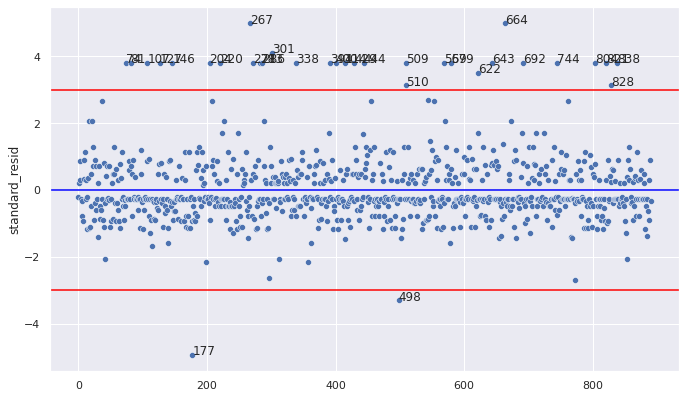

In [63]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=influence.summary_frame().index, y=influence.summary_frame().standard_resid)
plt.axhline(y=3, color='red')
plt.axhline(y=-3, color='red')
plt.axhline(y=0, color='blue')
fig.tight_layout(pad=2)
for i, txt in enumerate(inf.index.values):
    ax.annotate(txt, xy=(inf.index.values[i], inf.standard_resid.iloc[i]))

In [64]:
orig_train[orig_train.PassengerId.isin(train.iloc[inf.index.values,:].PassengerId)].sort_values(by='Age')

PassengerId  Survived  Pclass  \
220          221         1       3   
204          205         1       3   
283          284         1       3   
622          623         1       3   
664          665         1       3   
391          392         1       3   
127          128         1       3   
498          499         0       1   
271          272         1       3   
267          268         1       3   
509          510         1       3   
804          805         1       3   
821          822         1       3   
146          147         1       3   
510          511         1       3   
81            82         1       3   
286          287         1       3   
744          745         1       3   
74            75         1       3   
579          580         1       3   
838          839         1       3   
429          430         1       3   
569          570         1       3   
400          401         1       3   
414          415         1       3   
338          339         1       3   
177          178         0       1   
107          108         1       3   
301          302         1       3   
444          445         1       3   
643          644         1       3   
692          693         1       3   
828          829         1       3   

                                                Name     Sex   Age  SibSp  \
220                   Sunderland, Mr. Victor Francis    male  16.0      0   
204                         Cohen, Mr. Gurshon "Gus"    male  18.0      0   
283                       Dorking, Mr. Edward Arthur    male  19.0      0   
622                                 Nakid, Mr. Sahid    male  20.0      1   
664                      Lindqvist, Mr. Eino William    male  20.0      1   
391                           Jansson, Mr. Carl Olof    male  21.0      0   
127                        Madsen, Mr. Fridtjof Arne    male  24.0      0   
498  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0      1   
271                     Tornquist, Mr. William Henry    male  25.0      0   
267                         Persson, Mr. Ernst Ulrik    male  25.0      1   
509                                   Lang, Mr. Fang    male  26.0      0   
804                          Hedman, Mr. Oskar Arvid    male  27.0      0   
821                                Lulic, Mr. Nikola    male  27.0      0   
146     Andersson, Mr. August Edvard ("Wennerstrom")    male  27.0      0   
510                         Daly, Mr. Eugene Patrick    male  29.0      0   
81                       Sheerlinck, Mr. Jan Baptist    male  29.0      0   
286                          de Mulder, Mr. Theodore    male  30.0      0   
744                               Stranden, Mr. Juho    male  31.0      0   
74                                     Bing, Mr. Lee    male  32.0      0   
579                              Jussila, Mr. Eiriik    male  32.0      0   
838                                  Chip, Mr. Chang    male  32.0      0   
429               Pickard, Mr. Berk (Berk Trembisky)    male  32.0      0   
569                                Jonsson, Mr. Carl    male  32.0      0   
400                               Niskanen, Mr. Juha    male  39.0      0   
414                        Sundman, Mr. Johan Julian    male  44.0      0   
338                            Dahl, Mr. Karl Edwart    male  45.0      0   
177                       Isham, Miss. Ann Elizabeth  female  50.0      0   
107                           Moss, Mr. Albert Johan    male   NaN      0   
301                               McCoy, Mr. Bernard    male   NaN      2   
444                Johannesen-Bratthammer, Mr. Bernt    male   NaN      0   
643                                  Foo, Mr. Choong    male   NaN      0   
692                                     Lam, Mr. Ali    male   NaN      0   
828                     McCormack, Mr. Thomas Joseph    male   NaN      0   

     Parch             Ticket      Fare    Cabin Embarked  
220      0    SOTON/OQ 392089    

In [65]:
train.iloc[inf.index.values,:].shape[0]

33

In [66]:
train[(train['tit_Mr.']==1) & (train['Pcl_3']==1) & (train['Emb_S']==1)]

PassengerId  Survived  Pcl_2  Pcl_3  Emb_Q  Emb_S  tit_Miss.  tit_Mr.  \
0              1         0      0      1      0      1          0        1   
4              5         0      0      1      0      1          0        1   
12            13         0      0      1      0      1          0        1   
13            14         0      0      1      0      1          0        1   
29            30         0      0      1      0      1          0        1   
..           ...       ...    ...    ...    ...    ...        ...      ...   
876          877         0      0      1      0      1          0        1   
877          878         0      0      1      0      1          0        1   
878          879         0      0      1      0      1          0        1   
881          882         0      0      1      0      1          0        1   
884          885         0      0      1      0      1          0        1   

     tit_Mrs.  tit_Other  alo_1  
0           0          0      1  
4           0          0      0  
12          0          0      0  
13          0          0      1  
29          0          0      0  
..        ...        ...    ...  
876         0          0      0  
877         0          0      0  
878         0          0      0  
881         0          0      0  
884         0          0      0  

[245 rows x 11 columns]

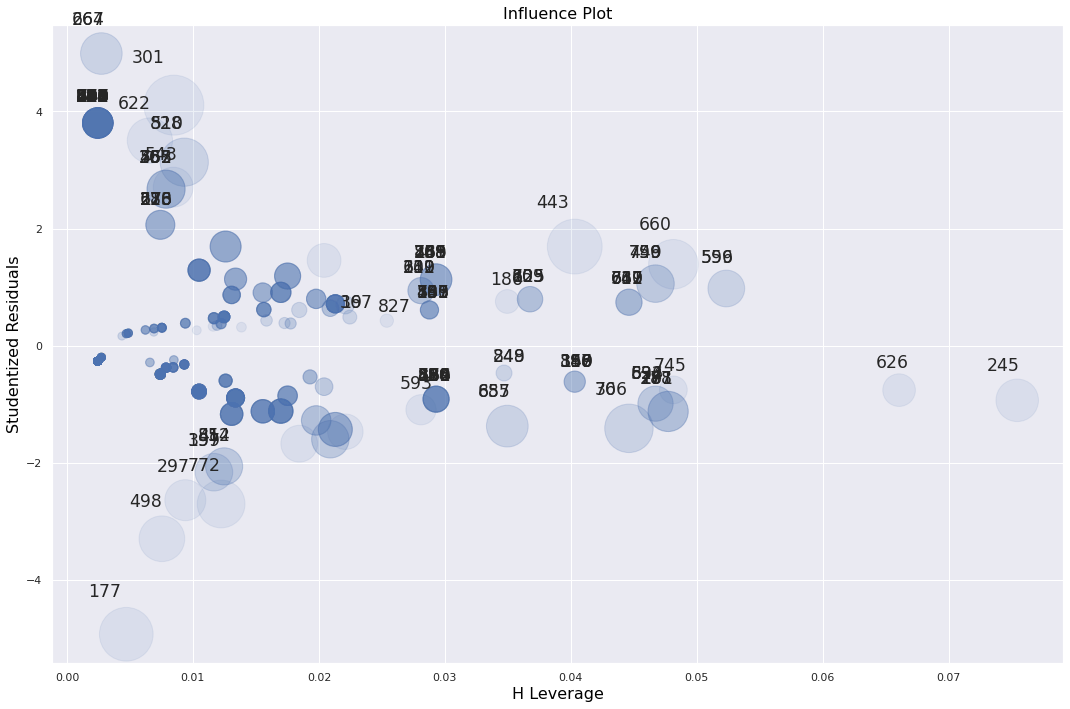

In [67]:
fig, ax = plt.subplots(figsize=(15,10))
influence = result.get_influence(observed=False)
influence.plot_influence(size=60, ax=ax, plot_alpha=0.1, criterion="cooks")
fig.tight_layout(pad=1.0)

In [68]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      881
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -387.65
Date:                Mon, 13 Feb 2023   Deviance:                       775.30
Time:                        10:29:38   Pearson chi2:                     968.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3698
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Pcl_2         -0.9441      0.269     -3.511      0.000      -1.471      -0.417
Pcl_3         -2.1727      0.247     -8.814      0.000      -2.656      -1.690
Emb_Q         -0.3168      0.379     -0.836      0.403      -1.060       0.426
Emb_S         -0.7113      0.236     -3.019      0.003      -1.173      -0.249
tit_Miss.     -0.0317      0.396     -0.080      0.936      -0.808       0.744
tit_Mr.       -3.0029      0.416     -7.225      0.000      -3.818      -2.188
tit_Mrs.       0.4156      0.415      1.003      0.316      -0.397       1.228
tit_Other     -2.5722      0.590     -4.361      0.000      -3.728      -1.416
alo_1         -0.5424      0.220     -2.470      0.014      -0.973      -0.112
const          3.2179      0.510      6.304      0.000       2.217       4.218
==============================================================================
"""

In [69]:
train1 = train.drop(index=inf.index.values)
y = train1['Survived']
X = train1.drop(columns=['Survived', 'PassengerId'])
X = sm.add_constant(X, prepend=False)
result = GLM(y, X, family=families.Binomial()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  858
Model:                            GLM   Df Residuals:                      848
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -271.68
Date:                Mon, 13 Feb 2023   Deviance:                       543.37
Time:                        10:29:38   Pearson chi2:                     697.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4915
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Pcl_2         -1.4310      0.347     -4.124      0.000      -2.111      -0.751
Pcl_3         -3.9888      0.402     -9.932      0.000      -4.776      -3.202
Emb_Q         -0.4644      0.438     -1.060      0.289      -1.323       0.394
Emb_S         -1.1682      0.276     -4.236      0.000      -1.709      -0.628
tit_Miss.     -0.0799      0.435     -0.184      0.854      -0.932       0.772
tit_Mr.       -4.8191      0.543     -8.883      0.000      -5.882      -3.756
tit_Mrs.       0.2037      0.459      0.443      0.657      -0.697       1.104
tit_Other     -4.1111      0.693     -5.931      0.000      -5.470      -2.753
alo_1         -0.5510      0.256     -2.156      0.031      -1.052      -0.050
const          5.1595      0.647      7.970      0.000       3.891       6.428
==============================================================================
"""

I will drop all indexes having standard_resid exceeding 3. 

In [70]:
train.drop(index=inf.index.values, inplace=True)

##### 5) Observation indipendence 

In [71]:
y = train['Survived']
X = train.drop(columns=['Survived', 'PassengerId'])
X = sm.add_constant(X, prepend=False)
result = GLM(y, X, family=families.Binomial()).fit()

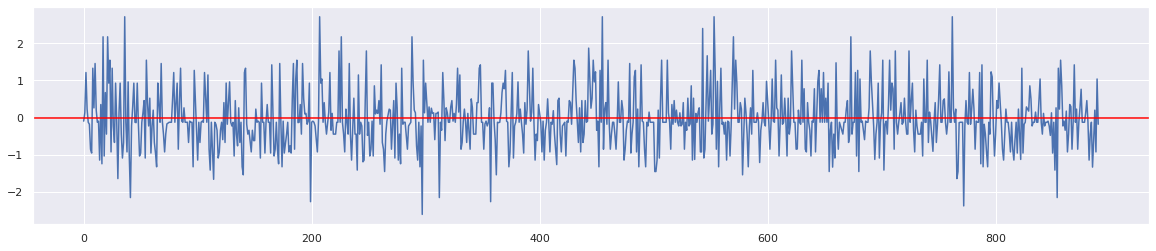

In [72]:
fig = plt.figure(figsize=(20,4))
sns.lineplot(x=X.index, y=result.resid_deviance)
plt.axhline(y=0, color='red');

The absence of non-random pattern show that the independence of errors is satisfied. 

##### 6) Sample size

In [73]:
cat, num = select_type(train)

In [74]:
for i in cat:
    print(train[i].value_counts())

0    674
1    184
Name: Pcl_2, dtype: int64
1    460
0    398
Name: Pcl_3, dtype: int64
0    784
1     74
Name: Emb_Q, dtype: int64
1    618
0    240
Name: Emb_S, dtype: int64
0    677
1    181
Name: tit_Miss., dtype: int64
1    486
0    372
Name: tit_Mr., dtype: int64
0    734
1    124
Name: tit_Mrs., dtype: int64
0    831
1     27
Name: tit_Other, dtype: int64
0    509
1    349
Name: alo_1, dtype: int64


# Building logistic model 

In [75]:
X = train.drop(columns=['PassengerId', 'Survived'])
y = train['Survived']

I will use Gridsearch to tune hyperparameters.

In [76]:
pipeline = Pipeline([('lr', LogisticRegression(random_state=0))])

pars = {#'lr__C': [1e-15, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 15],
        'lr__C': np.arange(0.2,1.9, 0.1),
        'lr__solver' : ['liblinear'],
        'lr__penalty' : ['l1']}

lr_grid = GridSearchCV(
          pipeline, 
          pars, 
          scoring='f1_macro',
          cv=12).fit(X, y)
lr_grid.best_params_

{'lr__C': 0.4000000000000001, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [78]:
pred_proba_df = pd.DataFrame(lr_grid.predict_proba(X_test))
#threshold_list = [0.35, 0.40, 0.45, 0.5, 0.55, 0.6, 0.65]
threshold_list = np.arange(0.51, 0.64, 0.01)
for i in threshold_list:
    print (f'\n For i = {i}')
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    print('F_score: ', f1_score(y_test, Y_test_pred.iloc[:,1], average='macro'))
    print(confusion_matrix(y_test, Y_test_pred.iloc[:,1]))


 For i = 0.51
F_score:  0.812898212898213
[[103   6]
 [ 22  41]]

 For i = 0.52
F_score:  0.812898212898213
[[103   6]
 [ 22  41]]

 For i = 0.53
F_score:  0.8186999804801874
[[104   5]
 [ 22  41]]

 For i = 0.54
F_score:  0.8186999804801874
[[104   5]
 [ 22  41]]

 For i = 0.55
F_score:  0.8186999804801874
[[104   5]
 [ 22  41]]

 For i = 0.56
F_score:  0.8186999804801874
[[104   5]
 [ 22  41]]

 For i = 0.5700000000000001
F_score:  0.8186999804801874
[[104   5]
 [ 22  41]]

 For i = 0.5800000000000001
F_score:  0.8186999804801874
[[104   5]
 [ 22  41]]

 For i = 0.5900000000000001
F_score:  0.8186999804801874
[[104   5]
 [ 22  41]]

 For i = 0.6000000000000001
F_score:  0.8186999804801874
[[104   5]
 [ 22  41]]

 For i = 0.6100000000000001
F_score:  0.8186999804801874
[[104   5]
 [ 22  41]]

 For i = 0.6200000000000001
F_score:  0.8091009988901221
[[105   4]
 [ 24  39]]

 For i = 0.6300000000000001
F_score:  0.7687324287984354
[[105   4]
 [ 29  34]]


In [79]:
y_prob = lr_grid.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
auc = auc(false_positive_rate, true_positive_rate)

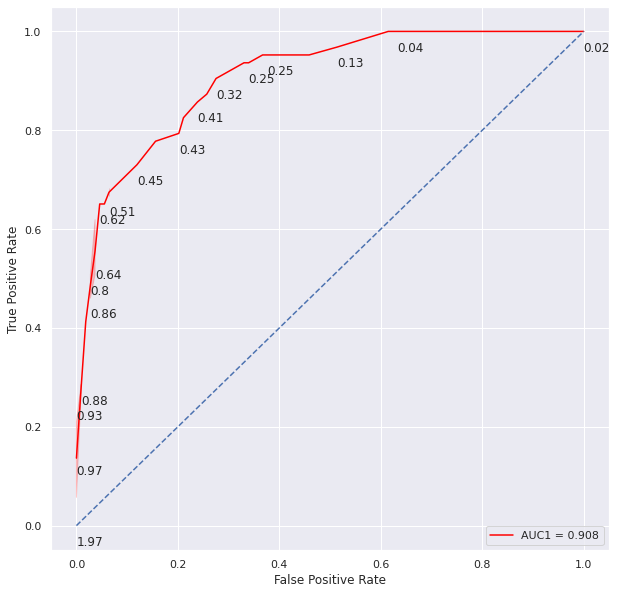

In [80]:
plt.figure(figsize=(10,10))
sns.lineplot(false_positive_rate, true_positive_rate, color='red',label = 'AUC1 = %0.3f' % auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
for i, j, txt in zip(false_positive_rate[::2], true_positive_rate[::2], thresholds[::2]):
    plt.annotate(np.round(txt,2), (i, j-0.04))

In [81]:
prob_y = np.array(pd.DataFrame(lr_grid.predict_proba(X_test)[:,1]).applymap(lambda x: 1 if x>0.56 else 0))

In [82]:
print(classification_report(y_test, prob_y))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       109
           1       0.89      0.65      0.75        63

    accuracy                           0.84       172
   macro avg       0.86      0.80      0.82       172
weighted avg       0.85      0.84      0.84       172



<AxesSubplot:>

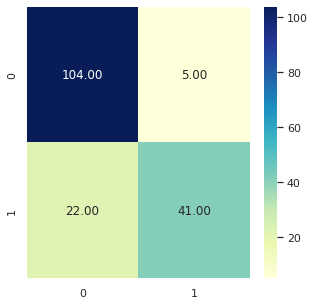

In [83]:
fig = plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, prob_y), annot=True, fmt='.2f', cmap="YlGnBu")

# Final result

In [84]:
prob_y = np.array(pd.DataFrame(lr_grid.predict_proba(test.drop(columns='PassengerId'))[:,1]).applymap(lambda x: 1 if x>0.59 else 0))

In [85]:
pred = prob_y.squeeze()
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': pred})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
